# Libraries

In [1]:
import os
import pandas as pd
import geopandas as gpd
import fiona
from functools import reduce
import matplotlib.pyplot as plt
import contextily as ctx
import libpysal as lps
import glob
from shapely.geometry import Polygon
from shapely.geometry import Point
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)

In [ ]:
#set working directory
os.chdir('C:/Users/amjar/Documents/Grad School/Capstone/Data/Cleaned')

# Load Cleaned Data

## Demographic/Administrative Data

In [3]:
emp_dens = pd.read_csv('emp_dens.csv')
pop_dens = pd.read_csv('pop_dens.csv')
race = gpd.read_file('race.geojson')
income = gpd.read_file('income.geojson')
tenure = gpd.read_file('tenure.geojson')
vehicles = pd.read_csv('vehicles.csv')
counties = gpd.read_file('counties.geojson')

### Combine

*** to do: join county boundaries to demog ***

In [4]:
census = [race, income, tenure, pop_dens, emp_dens]
demog = reduce(lambda  left,right: pd.merge(left,right,on=['geoid'],
                                            how='outer', suffixes=('', '_y')), census)
demog.drop(demog.filter(regex='_y$'),axis=1, inplace=True)
demog['Employment Density'] = demog['Total Employment']/demog['Area (land)']
demog['tract'] = demog['geoid'].str[:-1]
demog['tract'] = demog['tract'].str[7:]
demog = demog.astype({'tract': 'int64'})
demog['geoid'] = demog['geoid'].str[7:]
demog = demog.merge(vehicles, on='tract')
demog.drop(demog.filter(regex='^Unnamed:'),axis=1, inplace=True)
demog = demog.dropna(subset=['Median Household Income'])
demog['income_idx'] = pd.qcut(demog['Median Household Income'], 10, labels=['10','9','8','7','6','5','4','3','2','1'])
demog['race_idx'] = pd.qcut(demog['Percent Not Latinx White'], 10, labels=['1','2','3','4','5','6','7','8','9','10'])
demog['renter_idx'] = pd.qcut(demog['Percent Renter'], 10, labels=['1','2','3','4','5','6','7','8','9','10'])
demog['vehicle_idx'] = pd.qcut(demog['Percent 0 Vehicles'], 10, labels=['10','9','8','7','6','5','4','3','2','1'])
demog = demog.astype({'income_idx': 'int', 'race_idx': 'int', 'renter_idx': 'int', 'vehicle_idx': 'int'})
demog['EFC_score'] = demog['income_idx'] + demog['race_idx'] + demog['renter_idx'] + demog['vehicle_idx']

In [12]:
demog.to_file('C:/Users/amjar/Documents/Grad School/Capstone/Data/Cleaned/demog.geojson', driver='GeoJSON')

,geoid,name,Total,Not Latinx,White,Black,American Indian/Alaska Native,Asian,Native Hawaiian/Other Pacific Islander,Other,Two or more races,Latinx,Percent Not Latinx,Percent Latinx,Percent White,Percent Black,Percent American Indian/Alaska Native,Percent Asian,Percent Native Hawaiian/Other Pacific Islander,Percent Other,Percent Two or more races,Percent Not Latinx White,race_idx,geometry,Median Household Income,income_idx,Occupied Housing Units,Owner,Renter,Percent Owner,Percent Renter,Total Population,Population Density per sq mi,Area (land),Area Total,Area (land).1,Area (water),Total Employment,Employment Density,tract,Vehicle Households,0 Vehicles,1 Vehicle,2 Vehicles,3 Vehicles,4+ Vehicles,Percent 0 Vehicles,Percent 1 Vehicle,Percent 2 Vehicles,Percent 3 Vehicles,Percent 4+ Vehicles,renter_idx,vehicle_idx,EFC_score
0,480850301001,"Block Group 1, Collin, TX",1695.0,1191.0,1182.0,0.0,2.0,7.0,0.0,0.0,0.0,504.0,70.265487,29.734513,69.734513,0.000000,0.117994,0.412979,0.0,0.0,0.000000,30.265487,3,"MULTIPOLYGON (((-96.52154 33.39906, -96.52151 ...",75907.0,4,619.0,416.0,203.0,67.205170,32.794830,1695.0,60.23271,28.140856,28.357980,28.140860,0.217129,201.0,7.142640,48085030100,2049.0,22.0,382.0,782.0,637.0,226.0,1.073694,18.643241,38.164959,31.088336,11.029771,6,8,21
1,480850301002,"Block Group 2, Collin, TX",1809.0,1403.0,1358.0,8.0,0.0,0.0,0.0,0.0,37.0,406.0,77.556661,22.443339,75.069099,0.442233,0.000000,0.000000,0.0,0.0,2.045329,24.930901,3,"MULTIPOLYGON (((-96.48366 33.29393, -96.48359 ...",83125.0,4,526.0,468.0,58.0,88.973384,11.026616,1809.0,50.95837,35.499568,35.864800,35.499570,0.365233,33.0,0.929589,48085030100,2049.0,22.0,382.0,782.0,637.0,226.0,1.073694,18.643241,38.164959,31.088336,11.029771,2,8,17
2,480850301003,"Block Group 3, Collin, TX",2617.0,2026.0,1913.0,2.0,35.0,33.0,0.0,0.0,43.0,591.0,77.416890,22.583110,73.098968,0.076423,1.337409,1.260986,0.0,0.0,1.643103,26.901032,3,"MULTIPOLYGON (((-96.41921 33.31014, -96.41916 ...",59792.0,6,904.0,716.0,188.0,79.203540,20.796460,2617.0,43.77777,59.779199,60.502370,59.779200,0.723169,311.0,5.202479,48085030100,2049.0,22.0,382.0,782.0,637.0,226.0,1.073694,18.643241,38.164959,31.088336,11.029771,4,8,21
3,480850302011,"Block Group 1, Collin, TX",1945.0,1739.0,1525.0,154.0,6.0,5.0,0.0,0.0,49.0,206.0,89.408740,10.591260,78.406170,7.917738,0.308483,0.257069,0.0,0.0,2.519280,21.593830,2,"MULTIPOLYGON (((-96.58395 33.21063, -96.58393 ...",84167.0,4,614.0,489.0,125.0,79.641694,20.358306,1945.0,76.45770,25.438904,25.883860,25.438900,0.444959,289.0,11.360552,48085030201,1097.0,0.0,136.0,638.0,188.0,135.0,0.000000,12.397448,58.158614,17.137648,12.306290,4,10,20
4,480850302012,"Block Group 2, Collin, TX",1415.0,1158.0,1111.0,0.0,6.0,41.0,0.0,0.0,0.0,257.0,81.837456,18.162544,78.515901,0.000000,0.424028,2.897527,0.0,0.0,0.000000,21.484099,2,"MULTIPOLYGON (((-96.62352 33.24628, -96.62293 ...",84583.0,4,483.0,372.0,111.0,77.018634,22.981366,1415.0,144.79000,9.772774,9.844644,9.772775,0.071869,787.0,80.529846,48085030201,1097.0,0.0,136.0,638.0,188.0,135.0,0.000000,12.397448,58.158614,17.137648,12.306290,4,10,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4246,484971506022,"Block Group 2, Wise, TX",3540.0,2849.0,2784.0,31.0,11.0,3.0,0.0,0.0,20.0,691.0,80.480226,19.519774,78.644068,0.875706,0.310734,0.084746,0.0,0.0,0.564972,21.355932,2,"MULTIPOLYGON (((-97.47948 33.05412, -97.47947 ...",66512.0,5,1096.0,930.0,166.0,84.854015,15.145985,3540.0,187.54900,18.875071,18.875070,18.875070,0.000000,648.0,34.330996,48497150602,2455.0,58.0,513.0,1154.0,500.0,230.0,2.362525,20.896130,47.006110,20.366599,9.368635,3,6,16
4247,484971506023,"Block Group 3, Wise, TX",2232.0,1765.0,1607.0,6.0,5.0,0.0,0.0,0.0,147.0,467.0,79.077061,20.922939,71.998208,0.268817,0.224014,0.000000,0.0,0.0,6.586022,28.001792,3,"MULTIPOLYGON (((-97.50896 33

## City of Dallas data

In [ ]:
dal_crash_inter = gpd.read_file('dal_crash_inter.geojson')
pavement = gpd.read_file('dal_pavement.geojson')
bike_infra = gpd.read_file('dal_bike_infra.geojson')

In [15]:
fig.savefig('demog_EFC.jpg')

## Public Transportation

In [ ]:
rail_lines = gpd.read_file('rail_lines.geojson')
rail_stations = gpd.read_file('rail_stations.geojson')
bus_stops = gpd.read_file('bus_stops.geojson')

## City of Dallas

## Crash/Collision data

In [5]:
CRIS = gpd.read_file('CRIS_trim.geojson')

In [6]:
CRIS.to_crs(3857, inplace=True)

## Mobility 2045

In [ ]:
YR18 = gpd.read_file('YR18_trim.geojson')
YR45 = gpd.read_file('YR45_trim.geojson')
Mobility2045 = pd.merge(YR18_trim, YR45_trim, left_on='Shape_STLe_18', right_on='Shape_STLe_45')
Mobility2045 = gpd.GeoDataFrame(Mobility2045, geometry='geometry_45')

*** to do: assign street to county ***

In [ ]:
Mobility2045 = gpd.sjoin(Mobility2045, counties, how='left', op='intersects')

# Standardize Projections

*** to do: update list of datasets, check that project at this stage works ***

In [ ]:
### add all data to datasets list
datasets = [demog, rail_lines, rail_stations, bus_stops, CRIS, AADT, rd_inv, parks, HIN, pavement, bike_infra]
for file in datasets:
    file.to_crs(3857, inplace=True)

# Integrate datasets

## CRIS and demographic

### Crash Density

In [27]:
# code from https://stackoverflow.com/questions/54127731/how-can-i-count-the-number-of-polygons-a-shape-intersects
sindex = CRIS.sindex
# define empty list for results
results_list = []
# iterate over the points
for index, row in demog.iterrows():
    buffer = row['geometry'].buffer(804.672)  # buffer
    # find approximate matches with r-tree, then precise matches from those approximate ones
    possible_matches_index = list(sindex.intersection(buffer.bounds))
    possible_matches = CRIS.iloc[possible_matches_index]
    precise_matches = possible_matches[possible_matches.intersects(buffer)]
    results_list.append(len(precise_matches))
# add list of results as a new column
demog['CRIS_points'] = pd.Series(results_list)

In [31]:
#demog.to_file('C:/Users/amjar/Documents/Grad School/Capstone/Data/Cleaned/demog_CRIS.geojson', driver='GeoJSON')

### Fatal Crash Density

In [35]:
CRIS_fatal = CRIS.loc[CRIS['Crash Death Count'] > 0]
sindex = CRIS_fatal.sindex
# define empty list for results
results_list = []
# iterate over the points
for index, row in demog.iterrows():
    buffer = row['geometry'].buffer(804.672)  # buffer
    # find approximate matches with r-tree, then precise matches from those approximate ones
    possible_matches_index = list(sindex.intersection(buffer.bounds))
    possible_matches = CRIS_fatal.iloc[possible_matches_index]
    precise_matches = possible_matches[possible_matches.intersects(buffer)]
    results_list.append(len(precise_matches))
# add list of results as a new column
demog['CRIS_fatal_points'] = pd.Series(results_list)

### Save demog file w/geocoded crash data

In [38]:
demog.to_file('C:/Users/amjar/Documents/Grad School/Capstone/Data/Cleaned/demog_CRIS.geojson', driver='GeoJSON')

C:\Users\amjar\anaconda3\envs\spatial\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


## Associate crash location w/nearest street

In [42]:
CRIS_street = CRIS[['Crash ID', 'geometry']]
Mobility2045_crash = Mobility2045[['Shape_STLe_45', 'geometry_45']]
CRIS_street.to_crs(3857, inplace=True)
Mobility2045_crash.to_crs(3857, inplace=True)
street_crash = gpd.sjoin_nearest(CRIS_street, Mobility2045_crash, distance_col='distances')

In [44]:
street_crash

,Crash ID,geometry,index_right,Shape_STLe_45,distances
0,12210096,POINT (-10760576.679 3905828.901),1918,1851.661074,160.690704
15487,12990770,POINT (-10761117.427 3905583.916),1918,1851.661074,1.126357
17314,13062985,POINT (-10761117.427 3905583.916),1918,1851.661074,1.126357
17333,13062978,POINT (-10761117.427 3905583.916),1918,1851.661074,1.126357
26658,13640119,POINT (-10761117.427 3905583.916),1918,1851.661074,1.126357
...,...,...,...,...,...
2499015,17903401,POINT (-10875065.140 3943210.559),11542,1135.526137,134.261911
2499094,17920244,POINT (-10862853.799 3901821.813),11671,4808.637710,3.328069
2499158,17924437,POINT (-10858780.035 3940348.595),11523,9546.336339,8.027886
2499432,17997455,POINT (-10867223.538 3903700.262),11666,9152.047441,1.244444


In [ ]:
crash_by_street = street_crash.groupby(['Shape_STLe_45']).count()
crash_by_street.drop(columns=['geometry', 'index_right', 'distances'], inplace=True)
crash_by_street

In [67]:
Mobility2045_CRIS = pd.merge(Mobility2045, crash_by_street, how='left', on='Shape_STLe_45')
Mobility2045_CRIS['Crash ID'] =  Mobility2045_CRIS['Crash ID'].fillna(0)
Mobility2045_CRIS['segment_length'] = Mobility2045_CRIS.length
Mobility2045_CRIS['crash_per_meter'] = Mobility2045_CRIS['Crash ID'] / Mobility2045_CRIS['segment_length']
Mobility2045_CRIS.to_crs(3857, inplace=True)

## Park/Greenspace Per Capita

*** to do: create per capita measurement ***

In [ ]:
parks = gpd.read_file('parks.geojson')
parks.to_crs(3857, inplace=True)
parks['area'] = parks.geometry.area / 1000000

In [ ]:
sindex = parks.sindex
# define empty list for results
results_list = []
# iterate over the points
for index, row in demog_CRIS.iterrows():
    buffer = row['geometry'].buffer(1609.34)  # buffer
    # find approximate matches with r-tree, then precise matches from those approximate ones
    possible_matches_index = list(sindex.intersection(buffer.bounds))
    possible_matches = parks.iloc[possible_matches_index]
    precise_matches = possible_matches[possible_matches.intersects(buffer)]
    results_list.append(len(precise_matches))
# add list of results as a new column
demog_CRIS['park_access'] = pd.Series(results_list)

In [ ]:
demog['park_access'].value_counts()
demog.loc[demog['park_access'].isna()].plot()

## Save demog file + CRIS & park analysis output

In [ ]:
demog_CRIS.to_file('C:/Users/amjar/Documents/Grad School/Capstone/Data/Cleaned/demog_CRIS_parks.geojson', driver='GeoJSON')

# Analyze Excess Pavement

In [95]:
excess = Mobility2045_CRIS[['STREET_45', 'AMHRVOC_AB_18', 'AMHRVOC_BA_18', 'PMHRVOC_AB_18', 'PMHRVOC_BA_18','AMHRVOC_AB_45', 'AMHRVOC_BA_45', 'PMHRVOC_AB_45', 'PMHRVOC_BA_45', 'Shape_STLe_45', 'geometry_45']].copy()
excess['AMHRVOC_AB_AVG'] = (excess['AMHRVOC_AB_18']+excess['AMHRVOC_AB_45'])/2
excess['PMHRVOC_AB_AVG'] = (excess['PMHRVOC_AB_18']+excess['PMHRVOC_AB_45'])/2
excess['AMHRVOC_BA_AVG'] = (excess['AMHRVOC_BA_18']+excess['AMHRVOC_BA_45'])/2
excess['PMHRVOC_BA_AVG'] = (excess['PMHRVOC_BA_18']+excess['PMHRVOC_BA_45'])/2
excess

,STREET_45,AMHRVOC_AB_18,AMHRVOC_BA_18,PMHRVOC_AB_18,PMHRVOC_BA_18,AMHRVOC_AB_45,AMHRVOC_BA_45,PMHRVOC_AB_45,PMHRVOC_BA_45,Shape_STLe_45,geometry_45,AMHRVOC_AB_AVG,PMHRVOC_AB_AVG,AMHRVOC_BA_AVG,PMHRVOC_BA_AVG
0,LIBERTY DR,0.000000,0.000043,0.000000,0.000000,0.001022,0.000000,0.000000,0.000000,2655.162815,"LINESTRING (-10748858.191 3934218.951, -107488...",0.000511,0.000000,0.000022,0.000000
1,PENNSYLVANIA AVE,0.000000,0.000043,0.000000,0.000000,0.001022,0.000000,0.000000,0.000000,3478.601380,"LINESTRING (-10750035.951 3934511.145, -107499...",0.000511,0.000000,0.000022,0.000000
2,PARK VISTA BLVD,0.170197,0.843277,0.653526,0.270913,0.315048,0.379073,0.295059,0.382402,2693.453213,"LINESTRING (-10828307.691 3886209.026, -108282...",0.242622,0.474293,0.611175,0.326658
3,PARK VISTA BLVD,0.051266,0.282073,0.205141,0.072900,0.226538,0.203834,0.174759,0.244414,2708.684620,"LINESTRING (-10828320.270 3887187.746, -108283...",0.138902,0.189950,0.242953,0.158657
4,BASSWOOD BLVD,0.062479,0.000024,0.000020,0.030233,0.595827,0.000022,0.000055,0.452214,1832.843209,"LINESTRING (-10836697.396 3878416.398, -108365...",0.329153,0.000038,0.000023,0.241224
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26029,US67,0.396586,0.694277,0.498699,0.291356,0.360707,0.591711,0.424484,0.268376,26518.654278,"LINESTRING (-10855305.562 3804246.212, -108562...",0.378646,0.461591,0.642994,0.279866
26030,SH66,0.709940,0.966763,0.899941,0.713764,0.800256,1.391950,1.216069,0.797748,1167.244996,"LINESTRING (-10739274.808 3885835.280, -107392...",0.755098,1.058005,1.179356,0.755756
26031,SH34,0.357914,0.589635,0.492692,0.340613,0.416610,0.980597,0.726101,0.397050,11382.435832,"LINESTRING (-10741617.415 3815500.220, -107415...",0.387262,0.609397,0.785116,0.368831
26032,US380,0.652513,0.584192,0.562279,0.577332,1.368576,0.812797,0.822161,1.198405,5070.798334,"LINESTRING (-10738983.039 3917818.473, -107389...",1.010544,0.692220,0.698495,0.887868


In [96]:
excess['AMHRVOC_AB_AVG'].value_counts()

0.000000e+00    1408
1.950000e-05      12
3.000000e-06      11
1.500000e-06      11
5.000000e-07      10
                ... 
3.820000e-04       1
4.045000e-04       1
2.833855e-01       1
4.370550e-02       1
9.325905e-01       1
Name: AMHRVOC_AB_AVG, Length: 20825, dtype: int64

## Identify Streets with Volumes < 1

In [107]:
no_vol = Mobility2045_CRIS.loc[(Mobility2045_CRIS['AMVOL_45'] < 1) | (Mobility2045_CRIS['PMVOL_45'] < 1)]
no_vol

In [115]:
no_vol[['SPLTA_18', 'SPLTB_18', 'PKLNA_18', 'PKLNB_18']].median()

SPLTA_18    40.0
SPLTB_18    40.0
PKLNA_18     1.0
PKLNB_18     1.0
dtype: float64

In [ ]:
no_vol['COUNTY'].value_counts()

<AxesSubplot:>

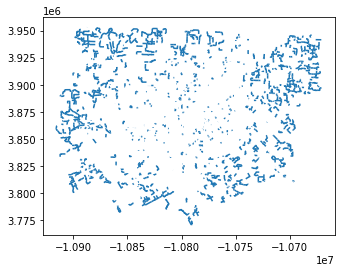

In [116]:
no_vol.plot()

# Maps

## Equity Index

In [ ]:
demog = demog.to_crs(3857)
fig, ax = plt.subplots(figsize=(20,20))
demog.plot(ax=ax, column='EFC_score',cmap='RdYlBu_r', legend=True)
ax.axis('off')
ax.set_title('Equity Index for NCTCOG')
#ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

In [ ]:
fig.savefig('demog_EFC.jpg')

## Crash Density

In [ ]:
fig, ax = plt.subplots(figsize=(20,20))

# add isochrones
demog.plot(ax=ax,
               column='CRIS_points',
               scheme='quantiles',
               cmap='RdYlBu_r',
               legend=True)

# no axis
ax.axis('off')

# title
ax.set_title('Crash Density')

# add a basemap
#ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

In [ ]:
fig.savefig('demog_CRIS.jpg')

## Fatal Crash Density

In [ ]:
fig, ax = plt.subplots(figsize=(20,20))

# add isochrones
demog.plot(ax=ax,
               column='CRIS_fatal_points',
               scheme='quantiles',
               k=10,
               cmap='RdYlBu_r',
               legend=True)

# no axis
ax.axis('off')

# title
ax.set_title('Fatal Crash Density')

# add a basemap
#ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

In [ ]:
fig.savefig('CRIS_fatal.jpg')

## Crashes by Street

In [ ]:
fig, ax = plt.subplots(figsize=(20,20))

# add isochrones
Mobility2045_CRIS.plot(ax=ax,
               column='Crash ID',
               scheme='quantiles',
               k=10,
               cmap='RdYlBu_r',
               legend=True)

# no axis
ax.axis('off')

# title
ax.set_title('Crashes by Street')

# add a basemap
#ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

## Crashes by Street per Meter

In [ ]:
fig, ax = plt.subplots(figsize=(20,20))

# add isochrones
Mobility2045_CRIS.plot(ax=ax,
               column='crash_per_meter',
               scheme='quantiles',
               k=10,
               cmap='RdYlBu_r',
               legend=True)

# no axis
ax.axis('off')

# title
ax.set_title('Crashes by Street per Meter')

# add a basemap
#ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

## Park Accessibility

In [ ]:
fig, ax = plt.subplots(figsize=(20,20))

# add isochrones
demog_CRIS.plot(ax=ax,
               column='park_access',
               scheme='quantiles',
               cmap='RdYlBu_r',
               legend=True)

# no axis
ax.axis('off')

# title
ax.set_title('Park Accessibility')

# add a basemap
#ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

In [ ]:
fig.savefig('park_access.jpg')